In [1]:
import pandas as pd

# Load the data sets
profiles_data = pd.read_csv('profiles.csv')
risk_data = pd.read_csv('risk.csv')

# show the columnns and missing values etc  ; could have used 

print("Columns of profiles data:")
print(profiles_data.columns)

print("\nColumns of risk data:")
print(risk_data.columns)


Columns of profiles data:
Index(['Unnamed: 0', 'ID', 'Sex', 'Age', 'Smoking', 'BMI',
       'Heart rate data used', 'MET (activity level)'],
      dtype='object')

Columns of risk data:
Index(['Unnamed: 0', 'ID', 'Diseases', 'risk'], dtype='object')


In [2]:
print("profiles dataset missing columns: \n", profiles_data.isnull().sum())
print("Number of rows in risk dataset mising columuns: \n ", risk_data.isnull().sum())

profiles dataset missing columns: 
 Unnamed: 0              0
ID                      0
Sex                     0
Age                     0
Smoking                 0
BMI                     0
Heart rate data used    0
MET (activity level)    0
dtype: int64
Number of rows in risk dataset mising columuns: 
  Unnamed: 0    0
ID            0
Diseases      0
risk          0
dtype: int64


# 
The age coulmn seems to have some issues as its not showing up as numbers though the excel has numbers

# 
On inspections there are some irrelavant values here , i think we should drop as its only two records, we could use imputers also 

	ID	Sex	Age	Smoking	BMI	Heart rate data used	MET (activity level)
151	152	M	588,899,521,531,101	no	21.49959688	1	70.4490787
192	193	M	326,288,448,393,712	no	22.99461451	1	13.28055556

In [3]:
# calculate the sum of cancer risks

cancer_data = risk_data[risk_data['Diseases'].str.contains('cancer', case=False)]

Cancer_Risk_Grouped = cancer_data.groupby(['ID'])['risk'].sum()

In [4]:
#merge onto the profiles data v by ID drop unwanted coulmns
merged_data = pd.merge(profiles_data, Cancer_Risk_Grouped, on='ID', how='left')
merged_data.drop(merged_data.columns[0],axis=1,inplace=True)
merged_data.drop(['ID'],axis=1,inplace=True)
print("data types" ,merged_data.dtypes)



data types Sex                      object
Age                      object
Smoking                  object
BMI                     float64
Heart rate data used    float64
MET (activity level)    float64
risk                    float64
dtype: object


#
i am dropping the missing cancer risks as i think the data should ideally have some value for each person
it could be that the misisng values are people with very low risks from general populatioin but we could try that out seprately and see if that improves the fit


In [5]:
# i am dropping the missing cancer risks as i think the data should ideally have some value for each person, cannot impute missing value of 0 also may be an avaerage may be misleading
# later i will probably also try xgboost to see if it can handle misisng valuesand improve fit ( it could be that the misisng values are people with very low risks from general populatioin)


# check the data

print(merged_data.describe())

# converting the age to float
# the weird age values are getting dropped from data 

merged_data = merged_data[pd.to_numeric(merged_data['Age'], errors='coerce').notnull()]
merged_data['Age'] = merged_data['Age'].astype(float)
merged_data['Heart rate data used'] = merged_data['Heart rate data used'].astype(str)
print(merged_data.describe())

              BMI  Heart rate data used  MET (activity level)        risk
count  233.000000            233.000000            233.000000  212.000000
mean    27.057882              0.626609             17.247569    0.585535
std     16.843256              0.484746             18.175526    0.368274
min      3.596908              0.000000              0.145333    0.001500
25%     22.913774              0.000000              5.404917    0.318900
50%     24.913495              1.000000             11.886912    0.488700
75%     28.507522              1.000000             22.805854    0.781575
max    270.416441              1.000000            117.923590    2.439100
              Age         BMI  MET (activity level)        risk
count  231.000000  231.000000            231.000000  211.000000
mean    39.998284   27.099534             17.034433    0.586918
std      9.489209   16.910184             17.910953    0.368598
min     22.999316    3.596908              0.145333    0.001500
25%     32.072

In [6]:
# take a copy of risks_with misisng values

filtered_data_wMis= merged_data

filtered_data=merged_data.dropna()

In [7]:
filtered_data.describe()

,Age,BMI,MET (activity level),risk
count,211.000000,211.000000,211.000000,211.000000
mean,39.939370,27.540538,13.125764,0.586918
std,9.469050,17.617916,10.759109,0.368598
min,22.999316,3.596908,0.145333,0.001500
25%,31.922078,23.093486,5.167336,0.320950
50%,39.964457,25.468471,10.628157,0.489100
75%,47.071770,28.833447,19.651632,0.784250
max,60.645249,270.416441,58.289505,2.439100


# 
doing some correlation and plot to understand the data including some of teh patterns in risk vs other variables

C:\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


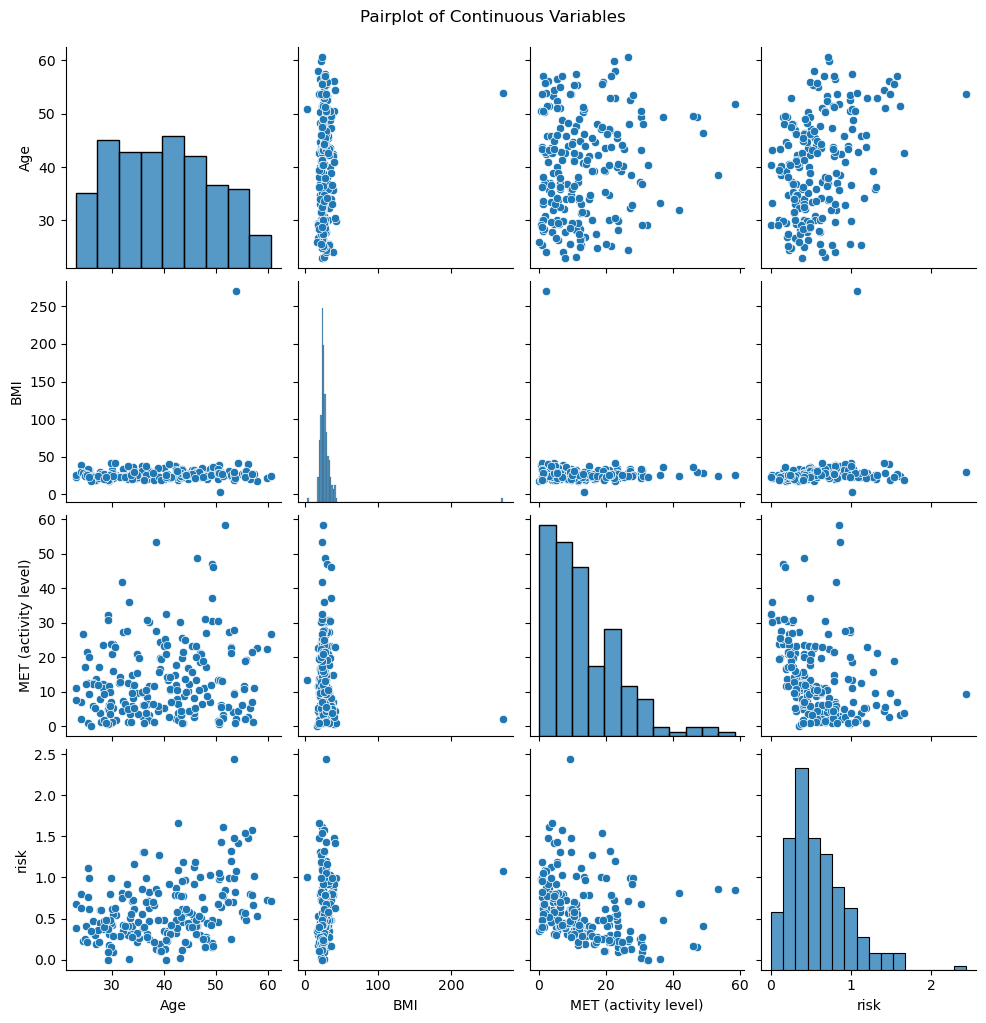

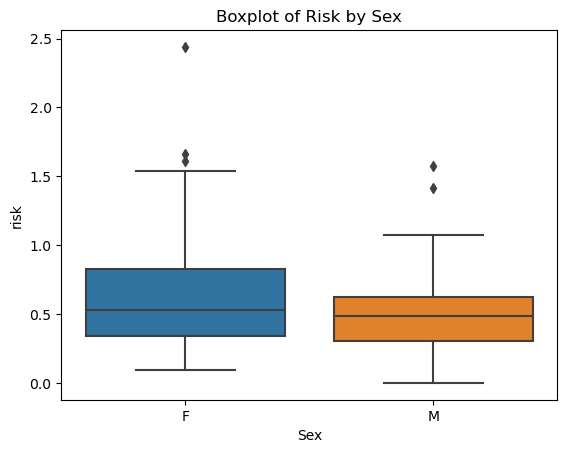

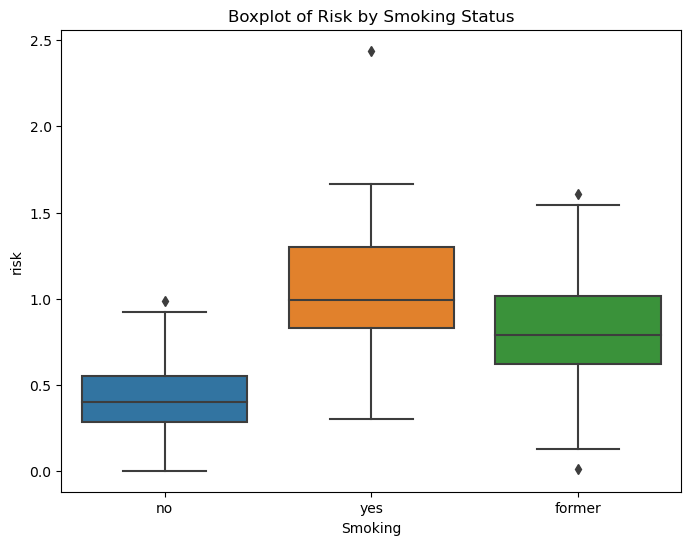

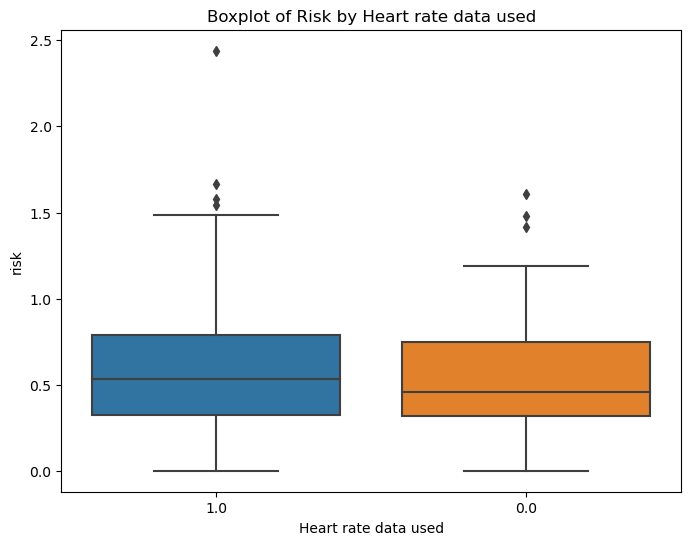

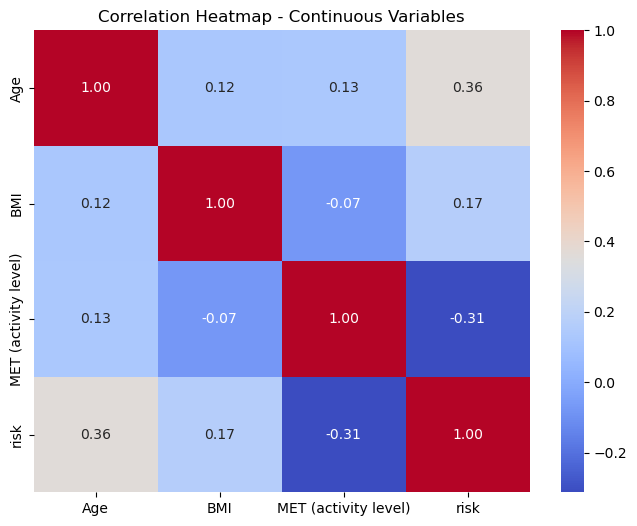

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(filtered_data[['Age', 'BMI', 'Heart rate data used', 'MET (activity level)', 'risk']])
plt.suptitle('Pairplot of Continuous Variables', y=1.02)
plt.show()

# Boxplot for categorical variables plt.figure(figsize=(8, 6))
sns.boxplot(x='Sex', y='risk', data=filtered_data)
plt.title('Boxplot of Risk by Sex')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Smoking', y='risk', data=filtered_data)
plt.title('Boxplot of Risk by Smoking Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Heart rate data used', y='risk', data=filtered_data)
plt.title('Boxplot of Risk by Heart rate data used')
plt.show()

# Correlation heatmap for continuous variables( later will do encoding)  , also just checking the correlation with risk
correlation_continuous = filtered_data[['Age', 'BMI',  'MET (activity level)', 'risk']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_continuous, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap - Continuous Variables')
plt.show()

#
there is an outlier in BMI , on inspecting th eexcel ( since its a small data set it turns out its likely a decimal place issue  270xxx instead of 27.0xxx but as practise i think we will just eliminate the record  ; others seems less critical from visualisation

In [9]:
Q1 = filtered_data['BMI'].quantile(0.25)
Q3 = filtered_data['BMI'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 2.576  * IQR   # approximating 99% cf interval
upper_bound = Q3 + 2.576  * IQR

# Exclude outliers in the BMI data
filtered_data = filtered_data[(filtered_data['BMI'] >= lower_bound) & (filtered_data['BMI'] <= upper_bound)]


# for MET I think none of the records are likely dropped but just testing here
Q1 = merged_data['MET (activity level)'].quantile(0.25)
Q3 = merged_data['MET (activity level)'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 2.576  * IQR
upper_bound = Q3 + 2.576  * IQR
filtered_data = filtered_data[(filtered_data['MET (activity level)'] >= lower_bound) & (filtered_data['MET (activity level)'] <= upper_bound)]



# 
I think we are  not dropping too many rows , and I think the DT regression algorithms are more likely to be resilient to outliers and I will change course if i am using linear regression

In [10]:
# I am not proceeding to check multicollinearity with VIF here but will do that separately

In [11]:
print(filtered_data.describe())

              Age         BMI  MET (activity level)        risk
count  209.000000  209.000000            209.000000  209.000000
mean    39.820818   26.493015             13.177336    0.582553
std      9.434708    5.090887             10.783680    0.367613
min     22.999316   17.226562              0.145333    0.001500
25%     31.841422   23.146952              5.221824    0.320000
50%     39.491456   25.468471             10.628157    0.488300
75%     46.974710   28.731747             19.654733    0.772300
max     60.645249   42.201019             58.289505    2.439100


#
Re-running the plot after the outliers

C:\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


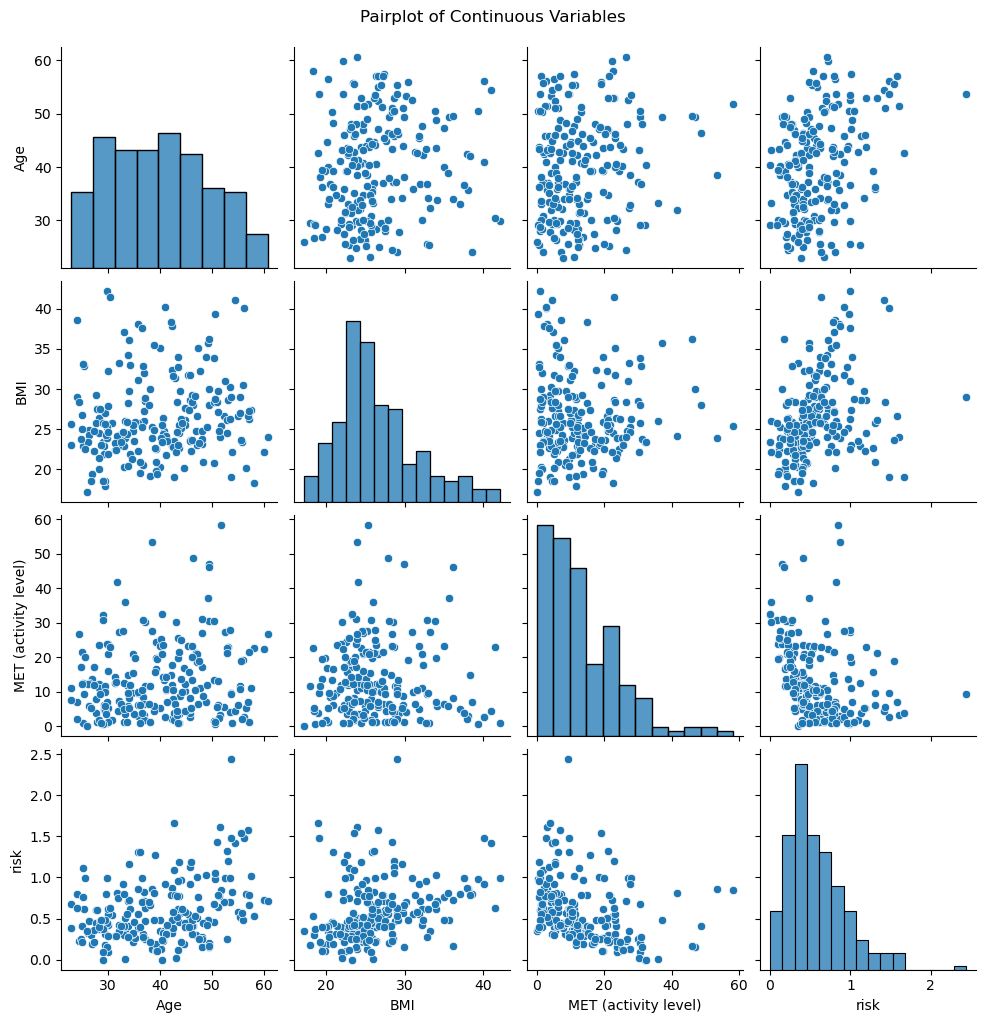

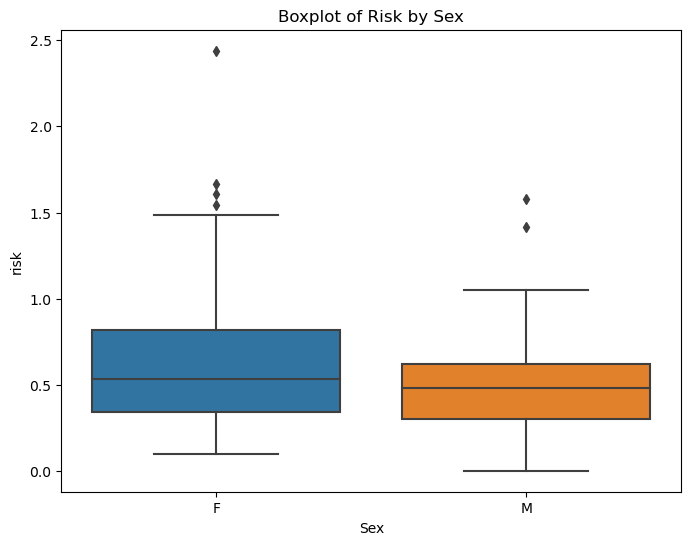

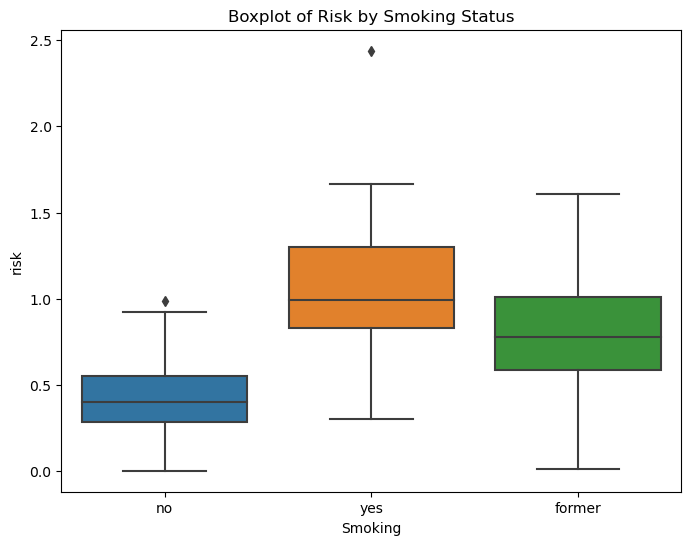

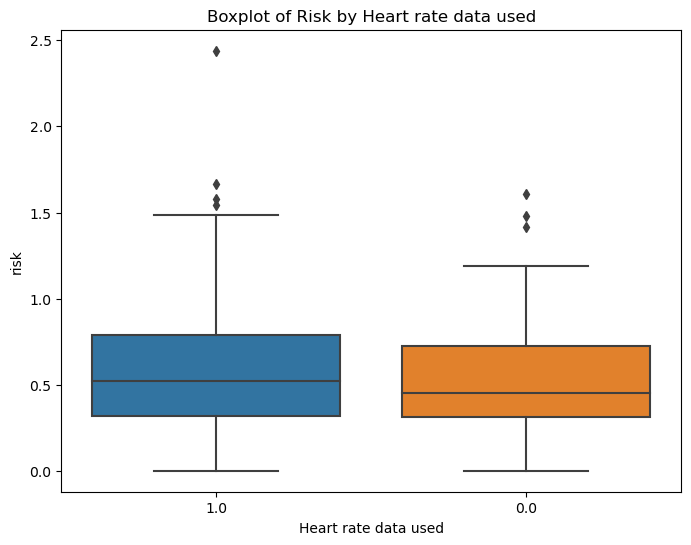

In [12]:

# plotting second time with records dropped
sns.pairplot(filtered_data[['Age', 'BMI', 'Heart rate data used', 'MET (activity level)', 'risk']])
plt.suptitle('Pairplot of Continuous Variables', y=1.02)
plt.show()

# Boxplot for categorical variables
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sex', y='risk', data=filtered_data)
plt.title('Boxplot of Risk by Sex')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Smoking', y='risk', data=filtered_data)
plt.title('Boxplot of Risk by Smoking Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Heart rate data used', y='risk', data=filtered_data)
plt.title('Boxplot of Risk by Heart rate data used')
plt.show()


# 
encoding to check correlation and VIF 

In [13]:
categorical_columns = filtered_data.select_dtypes(include=['object']).columns
numerical_columns = filtered_data.select_dtypes(include=['int', 'float']).columns

# Manual one-hot encoding using pandas get_dummies
encoded_categorical_df = pd.get_dummies(filtered_data[categorical_columns])


# Concatenation of encoded categorical and scaled numerical DataFrames
filtered_data_encoded = pd.concat([encoded_categorical_df, filtered_data[numerical_columns]], axis=1)
filtered_data_encoded['Sex_F']=filtered_data_encoded['Sex_F'].astype(int)
filtered_data_encoded['Sex_M']=filtered_data_encoded['Sex_M'].astype(int)
filtered_data_encoded['Smoking_former']=filtered_data_encoded['Smoking_former'].astype(int)
filtered_data_encoded['Heart rate data used_0.0']=filtered_data_encoded['Heart rate data used_0.0'].astype(int)
filtered_data_encoded['Heart rate data used_1.0']=filtered_data_encoded['Heart rate data used_1.0'].astype(int)
filtered_data_encoded['Smoking_yes']=filtered_data_encoded['Smoking_yes'].astype(int)
filtered_data_encoded['Smoking_no']=filtered_data_encoded['Smoking_no'].astype(int)

filtered_data_encoded.dtypes

Sex_F                         int32
Sex_M                         int32
Smoking_former                int32
Smoking_no                    int32
Smoking_yes                   int32
Heart rate data used_0.0      int32
Heart rate data used_1.0      int32
Age                         float64
BMI                         float64
MET (activity level)        float64
risk                        float64
dtype: object

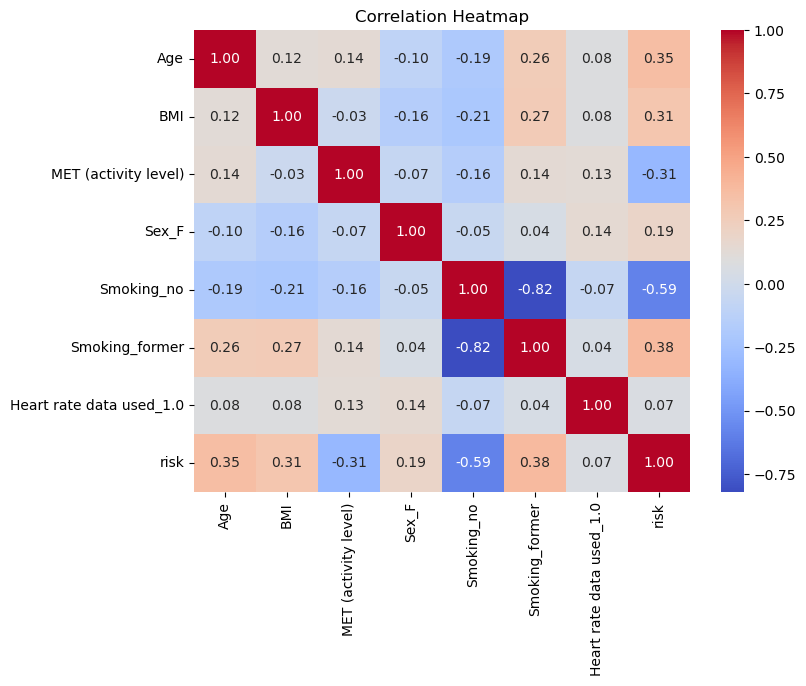

In [17]:
correlation_all = filtered_data_encoded[['Age', 'BMI',  'MET (activity level)','Sex_F','Smoking_no','Smoking_former',
'Heart rate data used_1.0','risk']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_all, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


#

from the plots its clear the 'smoking'='n' may have a very good importance in the model may be 'hear rate used' dont have much explainability , nit sure what this coulmn means ideally a better clarification of this column is needed There is also hint of relationships on age vs risk increasing, BMI vs risk inscreasing and MET vs risk decreasing Also evidenced by the correlations

I think probably we shouldnt consider binning of variables like Age, BMI as teh relationship in the pairplots sugests a smooth increase , not highly conclusive and some DT alogoriths may help in finding those cutoff points on the age, while related to other variables' where the risk is higher

# 
the VIF is done just to understand some interesting correlations

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Load the dataset into a DataFrame
# Add a constant term to the data to calculate VIF as a general practise so that the regressions  have an intercept
df_with_const = add_constant(filtered_data_encoded[['Age', 'BMI',  'MET (activity level)','Sex_M','Smoking_yes','Smoking_former',
'Heart rate data used_1.0','risk']].select_dtypes(include=['float64', 'int32']))
df_with_const.drop(['risk'],axis=1,inplace=True)
# Create a DataFrame to store the VIF results
vif_data = pd.DataFrame()
vif_data["feature"] = df_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]

print(vif_data)

                    feature        VIF
0                     const  46.418489
1                       Age   1.109219
2                       BMI   1.137773
3      MET (activity level)   1.066918
4                     Sex_M   1.084958
5               Smoking_yes   1.050808
6            Smoking_former   1.216817
7  Heart rate data used_1.0   1.062444


#
VIF > 1 and VIF < 5: This suggests moderate multicollinearity. While some correlation among the independent variables exists, it may not be severe enough to warrant corrective actions.


# 
from the plots its clear the 'smoking'='n' may have a very good importance in the model 
may be 'hear rate used' dont have much explainability , nit sure what this coulmn means ideally a better clarification of this column is needed
There is also hint of relationships on  age vs risk increasing, BMI vs risk inscreasing and MET vs risk decreasing  Also evidenced by the  correlations

I think probably we shouldnt consider binning of variables like Age, BMI as teh relationship in the pairplots sugests a smooth increase , not highly conclusive and some DT alogoriths may help in finding those cutoff points on teh age where the risk is higher

In [16]:
%store filtered_data
%store filtered_data_wMis

Stored 'filtered_data' (DataFrame)
Stored 'filtered_data_wMis' (DataFrame)
